In [4]:
import numpy as np
import torch

import matplotlib.pyplot as plt
from datamodules.aoj import AspenOpenJets 

aoj = AspenOpenJets(
    data_dir="/home/df630/Multimodal-Bridges/data/aoj", data_files="RunG_batch0.h5"
)

particle_set, _ = aoj(num_jets=10_000,
                      download=False,
                      features={"continuous": None, "discrete": "tokens"},
                      pt_order=True,
                      padding='zeros',
                      )

particle_set.mask = torch.ones_like(particle_set.discrete)


/home/df630/Multimodal-flows/multimodal_flows/datamodules/aoj.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_discrete_feats.append(torch.tensor(feats[features["discrete"]]))


<Axes: ylabel='Density'>

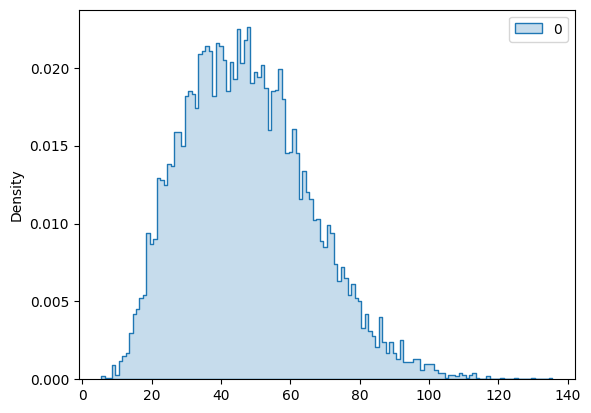

In [5]:
import seaborn as sns

sns.histplot((particle_set.discrete > 0).sum(dim=1), 
             discrete=True,
             stat="density",
             element="step",
             )

In [46]:
particle_set.discrete > 0

tensor([[[ True],
         [ True],
         [ True],
         ...,
         [False],
         [False],
         [False]],

        [[ True],
         [ True],
         [ True],
         ...,
         [False],
         [False],
         [False]],

        [[ True],
         [ True],
         [ True],
         ...,
         [False],
         [False],
         [False]],

        ...,

        [[ True],
         [ True],
         [ True],
         ...,
         [False],
         [False],
         [False]],

        [[ True],
         [ True],
         [ True],
         ...,
         [False],
         [False],
         [False]],

        [[ True],
         [ True],
         [ True],
         ...,
         [False],
         [False],
         [False]]])

In [10]:
data.target

TensorMultiModal(time=None, continuous=None, discrete=tensor([[[1],
         [1],
         [3],
         ...,
         [0],
         [0],
         [0]],

        [[4],
         [3],
         [4],
         ...,
         [0],
         [0],
         [0]],

        [[4],
         [1],
         [3],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[4],
         [1],
         [3],
         ...,
         [0],
         [0],
         [0]],

        [[3],
         [3],
         [1],
         ...,
         [0],
         [0],
         [0]],

        [[1],
         [4],
         [3],
         ...,
         [0],
         [0],
         [0]]]), mask=tensor([[[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [1]],

        [[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [1]],

        [[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [1]],

        ...,

        [[1]

In [14]:
dataset.data.target

TensorMultiModal(time=None, continuous=None, discrete=tensor([[[1],
         [1],
         [3],
         ...,
         [0],
         [0],
         [0]],

        [[4],
         [3],
         [4],
         ...,
         [0],
         [0],
         [0]],

        [[4],
         [1],
         [3],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[4],
         [1],
         [3],
         ...,
         [0],
         [0],
         [0]],

        [[3],
         [3],
         [1],
         ...,
         [0],
         [0],
         [0]],

        [[1],
         [4],
         [3],
         ...,
         [0],
         [0],
         [0]]]), mask=tensor([[[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [1]],

        [[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [1]],

        [[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [1]],

        ...,

        [[1]

In [6]:
from torch.utils.data import DataLoader, random_split
from tensorclass import TensorMultiModal
from datamodules.datasets import MultiModalDataset, DataCoupling, data_coupling_collate_fn

data = DataCoupling(source=TensorMultiModal(), target=particle_set)
dataset = MultiModalDataset(data)
batch_size = 128

train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=data_coupling_collate_fn)
val_dataloader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, collate_fn=data_coupling_collate_fn)

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [4]:
import torch

from transformers import GPT2LMHeadModel, GPT2Config

class PermutationInvariantGPT2LMHeadModel(GPT2LMHeadModel):
    """
    A GPT2LMHeadModel with the causal mask removed (i.e. attention is
    fully permutation-invariant).  Everything else (positional embeddings,
    layer structure, LM head, etc.) is identical to vanilla GPT-2.
    """

    def __init__(self, config: GPT2Config):
        super().__init__(config)
        # Overwrite each layer's causal bias buffer so that it's all 1s
        # (so no positions get masked out)
        for block in self.transformer.h:
            # `block.attn.bias` is a buffer of shape [1,1,seq_len,seq_len]
            # the lower‐triangular mask.  Fill it with ones → no masking.
            block.attn.bias.data.fill_(1)

        # Re-initialize weights if you like, or keep pretrained ones:
        # self.init_weights()


    def forward(
        self,
        input_ids=None,
        past_key_values=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        **kwargs
    ):
        """
        Same signature as GPT2LMHeadModel, but any causal masking
        has been neutralized.  You can still optionally pass an
        `attention_mask` for padding or other custom masks.
        """
        return super().forward(
            input_ids=input_ids,
            past_key_values=past_key_values,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            **kwargs
        )

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as L
from typing import List, Tuple, Dict, Union

from torch.optim.lr_scheduler import CosineAnnealingLR

from tensorclass import TensorMultiModal
from datamodules.datasets import DataCoupling

from model.solvers import DiscreteSolver
from model.bridges import TelegraphBridge
from model.thermostats import Thermostat

class ConstantThermostat(Thermostat):
    ''' beta(r) = const.
    '''
    def _integral(self, t0, t1):
        return t1 - t0


class MarkovJumpBridge(L.LightningModule):
    """Bridge-Matching model for multi-modal data"""

    def __init__(self, 
                 gamma=0.075, 
                 vocab_size=9,
                 num_jets=30000,
                 max_num_particles=150,
                 lr_final=0.0001,
                 lr=0.001,
                 max_epochs=100,
                 time_eps=1e-5,
                 ):
        super().__init__()

        self.gamma = gamma
        self.vocab_size = vocab_size
        self.path_snapshots_idx = True
        self.num_jets = num_jets
        self.max_num_particles = max_num_particles
        self.lr_final = lr_final
        self.lr = lr
        self.max_epochs = max_epochs
        self.time_eps = time_eps

        thermostat = ConstantThermostat(self.gamma , self.vocab_size)

        self.telegraph_bridge = TelegraphBridge(gamma=self.gamma ,
                                                vocab_size=self.vocab_size,
                                                thermostat_fn=thermostat,
                                                )
        self.save_hyperparameters()

        config = GPT2Config(vocab_size=self.vocab_size, 
                            n_positions=self.max_num_particles,  
                            n_ctx=self.max_num_particles,  
                            n_embd=128,
                            n_layer=4,
                            n_head=4,
                            activation_function='gelu_new',
                            attn_pdrop=0.1,
                            embd_pdrop=0.1,
                            resid_pdrop=0.1,
                        )

        self.model = PermutationInvariantGPT2LMHeadModel(config)

    # ...Lightning functions

    def forward(self, state: TensorMultiModal, batch: DataCoupling) -> TensorMultiModal:
        
        return self.model(input_ids=state.discrete.squeeze(-1).long(), 
                          attention_mask=state.mask.squeeze(-1).long(),
                          )
        
    def training_step(self, batch: DataCoupling, batch_idx) -> Dict[str, torch.Tensor]:

        state = self.sample_bridges(batch)
        state = state.to(self.device)
        target = batch.target.discrete.squeeze(-1).to(self.device)

        print(state.discrete.shape, state.mask.shape, target.shape)
        

        outputs = self.model(input_ids=state.discrete.squeeze(-1).long(),
                             attention_mask=state.mask.squeeze(-1).long(),
                             labels=target,
                            )
        loss = outputs.loss

        return {"loss": loss}

    def validation_step(self, batch: DataCoupling, batch_idx) -> Dict[str, torch.Tensor]:
        state = self.sample_bridges(batch)
        state = state.to(self.device)
        target = batch.target.discrete.squeeze(-1).to(self.device)

        outputs = self.model(input_ids=state.discrete.squeeze(-1).long(),
                             attention_mask=state.mask.squeeze(-1).long(),
                             labels=target.long(),
                            )
        loss = outputs.loss

        return {"val_loss": loss}

    def predict_step(
        self, batch: DataCoupling, batch_idx
    ) -> Tuple[TensorMultiModal, TensorMultiModal, TensorMultiModal]:

        """generate target data from source by solving EOMs
        """

        source_tokens = torch.randint(0, 
                                      self.vocab_size, 
                                      (self.num_jets, self.max_num_particles, 1), 
                                      device=self.device)

        mask = torch.ones((self.num_jets, 
                           self.max_num_particles, 1), 
                           device=self.device).long()

        batch.source = self.sample_source(
                shape=batch.target.shape, device=self.device, sample_masks=False
            )

        source_state = TensorMultiModal(
            torch.zeros_like(mask),
            None,
            source_tokens,
            mask,
        )  # t=0

        paths = self.simulate_dynamics(source_state, batch)  # still preprocessed!

        return paths.detach().cpu()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)

        scheduler = CosineAnnealingLR(
            optimizer,
            T_max=self.max_epochs,    # full cycle length
            eta_min=self.lr_final             # final LR
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",   
                "frequency": 1,
                "strict": True,
            },
        }

    # ...Model functions

    def sample_bridges(self, batch: DataCoupling) -> TensorMultiModal:
        """sample stochastic bridges
        """

        eps = self.time_eps  # min time resolution
        t = eps + (1 - eps) * torch.rand(len(batch), device=self.device)
        time = self.reshape_time_dim_like(t, batch)

        source_tokens = torch.randint(0, self.vocab_size, (len(batch), self.max_num_particles, 1), device=self.device)
        mask = torch.ones((len(batch), 
                           self.max_num_particles, 1), 
                           device=self.device).long()

        batch.source = TensorMultiModal(None, None, source_tokens, mask)
        noisy_tokens = self.telegraph_bridge.sample(time, batch)

        return TensorMultiModal(time, None, noisy_tokens, mask)

    def simulate_dynamics(
        self, state: TensorMultiModal, batch: DataCoupling
    ) -> TensorMultiModal:
        """generate target data from source input using trained dynamics
        returns the final state of the bridge at the end of the time interval
        """
        eps = self.config.model.time_eps  # min time resolution
        steps = self.config.model.num_timesteps
        time_steps = torch.linspace(eps, 1.0 - eps, steps, device=self.device)
        delta_t = (time_steps[-1] - time_steps[0]) / (len(time_steps) - 1)

        solver_discrete = DiscreteSolver(self.config, model=self)

        paths = [state.clone()]  # append t=0 source

        for i, t in enumerate(time_steps):
            is_last_step = (i == len(time_steps) - 1)
            state.time = torch.full((len(batch), 1), t.item(), device=self.device)
            state = solver_discrete.fwd_step(state, batch, delta_t, is_last_step)
            state.broadcast_time()  # (B,1) -> (B,D,1)
            
            if isinstance(self.path_snapshots_idx, list):
                for i in self.path_history_idx:
                    paths.append(state.clone())

        # if state.has_discrete:
        #     max_rate = torch.max(rates, dim=2)[1]
        #     state.discrete = max_rate.unsqueeze(-1)

        paths.append(state)  # append t=1 generated target
        paths = TensorMultiModal.stack(paths, dim=0)
        return paths

    def reshape_time_dim_like(self, t, state: Union[TensorMultiModal, DataCoupling]):
        if isinstance(t, (float, int)):
            return t
        else:
            return t.reshape(-1, *([1] * (state.ndim - 1)))


In [ ]:
import numpy as np
import pandas as pd
import torch
import os
from pathlib import Path
import awkward as ak
import vector
import fastjet
import yaml
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from pytorch_lightning.callbacks import Callback
from lightning.pytorch.utilities import rank_zero_only
from sklearn.metrics import roc_curve, auc

from datamodule_jetclass import JetSequence

vector.register_awkward()

# TODO TODO

class GeneratorCallback(Callback):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.experiment_dir = Path(f'{config.dir}/{config.project_name}/{config.experiment_id}')
        self.jet_type = config.jet_type
        self.data_dir = f'{config.dir}/JetClass' 
        self.tag = config.tag
        self.max_seq_length=config.max_seq_length

    def on_predict_start(self, trainer, pl_module):
        self.batched_data = []
        self.predict_type = trainer.model.predict_type
        self.start_token = trainer.model.start_token
        self.end_token = trainer.model.end_token
        self.pad_token = trainer.model.pad_token
        self.file_name = f'{self.predict_type}_{self.jet_type}_seq_{self.tag}'

    def on_predict_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx):
        self.batched_data.append(outputs)

    def on_predict_end(self, trainer, pl_module):
        rank = trainer.global_rank

        self._save_results_local(rank)
        trainer.strategy.barrier()  # wait for all ranks to finish

        if trainer.is_global_zero:
            self._gather_results_global(trainer)
            self._clean_temp_files()

    def _save_results_local(self, rank):
        data = torch.cat(self.batched_data, dim=0)
        random = np.random.randint(0, 1000)
        path = f"{self.experiment_dir}/{self.predict_type}_temp_data_{rank}_{random}.pt"
        torch.save(data, path)

    @rank_zero_only
    def _gather_results_global(self, trainer):
        
        os.mkdir(f'{self.experiment_dir}/{self.predict_type}_results_{self.tag}')

        with open(f'{self.experiment_dir}/{self.predict_type}_results_{self.tag}/configs.yaml' , 'w' ) as outfile:
            yaml.dump( self.config.__dict__, outfile, sort_keys=False)

        temp_files = self.experiment_dir.glob(f"{self.predict_type}_temp_data_*_*.pt")
        data_tokens = torch.cat([torch.load(str(f)) for f in temp_files], dim=0)

        print(f'INFO: first event: {data_tokens[0]}')

        np.save(f'{self.experiment_dir}/{self.predict_type}_results_{self.tag}/{self.file_name}_tokens.npy', data_tokens)
        print(f'\nINFO: generated {data_tokens.shape[0]} jet sequences')
        print(f'INFO: data saved in {self.experiment_dir}/{self.predict_type}_results_{self.tag}')

        Jets = JetSequence()
        data_tokens = torch.where(data_tokens>=self.start_token, -1 * torch.ones_like(data_tokens), data_tokens)
        data_binned = binnify(Jets.seq_to_bins_decoding(data_tokens[:, 1:]), self.data_dir) # rm start token

        np.save(f'{self.experiment_dir}/{self.predict_type}_results_{self.tag}/{self.file_name}_binned.npy', data_binned)
        print(f'INFO: saved binned jets with shape {data_binned.shape}')

        if self.config.plots:
            print('INFO: plotting results...')
            self._plot_results(data_binned, 
                            path=f'{self.experiment_dir}/{self.predict_type}_results_{self.tag}', 
                            N=100_000
                            )

    def _clean_temp_files(self):
        for f in self.experiment_dir.glob(f"{self.predict_type}_temp_data_*_*.pt"):
            f.unlink()


In [6]:
import numpy as np
import torch

import matplotlib.pyplot as plt
from datamodules.aoj import AspenOpenJets 

aoj = AspenOpenJets(
    data_dir="/home/df630/Multimodal-Bridges/data/aoj", data_files="RunG_batch0.h5"
)

particle_set, _ = aoj(num_jets=5_000,
                      download=False,
                      features={"continuous": None, "discrete": "tokens"},
                      pt_order=True,
                      padding='zeros',
                      )

particle_set.mask = torch.ones_like(particle_set.discrete)


/home/df630/Multimodal-flows/multimodal_flows/datamodules/aoj.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_discrete_feats.append(torch.tensor(feats[features["discrete"]]))


In [1]:
import torch
from pytorch_lightning.loggers import CometLogger
import pytorch_lightning as L
from torch.utils.data import DataLoader, random_split
from tensorclass import TensorMultiModal
from datamodules.datasets import MultiModalDataset, DataCoupling, data_coupling_collate_fn
from model.multimodal_bridge_matching import MarkovJumpBridge


experiment_id = '01a13cfa5e0a4c02b6df030f11dcbf50'
vocab_size = 9
num_jets = 5000
max_num_particles = 150
batch_size=100

mjb = MarkovJumpBridge.load_from_checkpoint(f"/home/df630/Multimodal-flows/jet_sequences/{experiment_id}/checkpoints/best.ckpt", map_location="cpu",)
mjb.num_timesteps = 3000


In [2]:
noise = torch.randint(0, vocab_size, (num_jets, max_num_particles, 1))
mask = torch.ones((num_jets, max_num_particles, 1))
source = TensorMultiModal(discrete=noise, mask=mask)

data = DataCoupling(source=source, target=TensorMultiModal())
dataset = MultiModalDataset(data)
predict_dataloader   = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=data_coupling_collate_fn)


In [3]:
generator = L.Trainer(accelerator="gpu", 
                      devices=[0], 
                      )

x = generator.predict(mjb, dataloaders=predict_dataloader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/df630/.conda/envs/multiflows/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 3000 steps
INFO: Simulating 300

In [4]:
X = torch.cat([xx.discrete for xx in x], dim=1).squeeze(-1).cpu()

In [12]:
X[1][0]

tensor([4, 1, 3, 4, 1, 2, 4, 4, 3, 1, 2, 2, 4, 2, 3, 4, 3, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])

In [13]:
X[1][0]

tensor([4, 1, 3, 4, 1, 2, 4, 4, 3, 1, 2, 2, 4, 2, 3, 4, 3, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])

<Axes: ylabel='Density'>

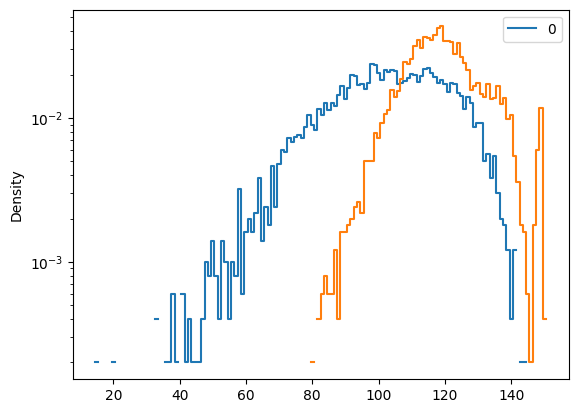

In [21]:
import seaborn as sns

n = 0

sns.histplot((particle_set.discrete == n).sum(dim=1), 
             discrete=True,
             stat="density",
             element="step",
             fill=False,
             log_scale=(False, True),
             )


sns.histplot((X[1] == n).sum(dim=1),
                discrete=True,
                stat="density",
                element="step",
                fill=False,
                log_scale=(False, True),
                )

# sns.histplot((X[0] == n).sum(dim=1),
#                 discrete=True,
#                 stat="density",
#                 element="step",
#                 fill=False,
#                 log_scale=(False, True),
#                 )

<Axes: ylabel='Density'>

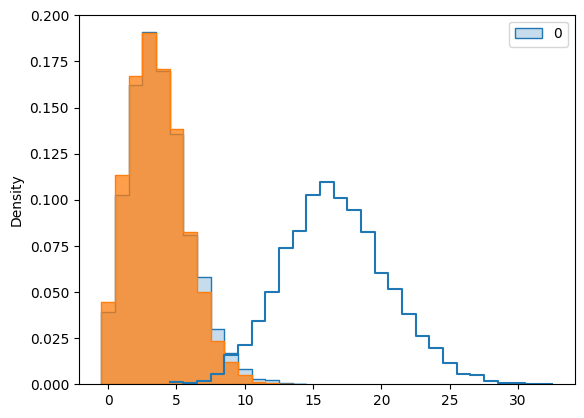

In [19]:
import seaborn as sns

n = 2

sns.histplot((particle_set.discrete == n).sum(dim=1), 
             discrete=True,
             stat="density",
             element="step",
             )


sns.histplot((X[1] == n).sum(dim=1),
                discrete=True,
                stat="density",
                element="step",
                )

sns.histplot((X[0] == n).sum(dim=1),
                discrete=True,
                stat="density",
                element="step",
                fill=False,
                )

In [20]:
X[1].flatten() == 0

array([ True, False, False, ..., False, False, False], shape=(150000,))

## Token ocurrence per jet

In [4]:
token_freqs = torch.tensor(
    [
        (data.isPhoton.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
        (data.isNeutralHadron.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
        (data.isNegativeHadron.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
        (data.isPositiveHadron.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
        (data.isElectron.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
        (data.isPositron.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
        (data.isMuon.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
        (data.isAntiMuon.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
    ]
)

In [12]:
batch = next(iter(train_dataloader))
state = mjb.sample_bridges(batch).to(mjb.device)
target = batch.target.discrete.squeeze(-1).to(mjb.device)

# run one forward+loss
outputs = mjb.model(
    input_ids      = state.discrete.squeeze(-1).long(),
    attention_mask= state.mask.squeeze(-1).long(),
    labels         = target.long(),
)
print("✔ forward OK, loss=", outputs.loss.item())

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


✔ forward OK, loss= 2.0418574810028076


tensor([[ 0., 10.,  3.,  ...,  0.,  0.,  0.],
        [ 0., 13.,  1.,  ...,  0.,  0.,  1.],
        [ 0.,  3.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  9.,  1.,  ...,  0.,  1.,  0.],
        [ 0.,  6.,  1.,  ...,  0.,  1.,  0.],
        [ 0., 29.,  4.,  ...,  0.,  0.,  0.]])


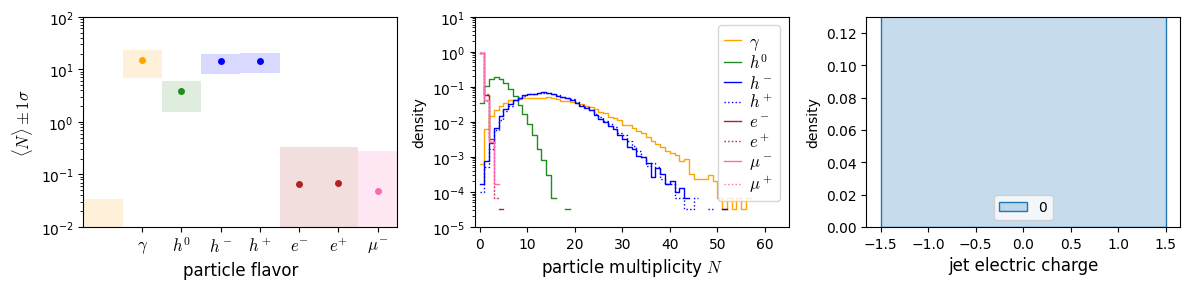

In [7]:
_, ax = plt.subplots(1, 3, figsize=(12, 3))

jets.plot_flavor_count_per_jet(
    markersize=8,
    color=[
        "orange",
        "orange",
        "forestgreen",
        "blue",
        "blue",
        "firebrick",
        "firebrick",
        "hotpink",
        "hotpink",
    ],
    ax=ax[0],
)

fill = False
alpha = 1 

data.histplot('num_Photon',ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100), binwidth=1,log_scale=(False, True),  stat='density', color='orange',lw=1,  label=r'$\gamma$')
data.histplot("num_NeutralHadron",  ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100), binwidth=1, log_scale=(False, True),  stat='density', color='forestgreen',lw=1,  label=r'$h^0$')
data.histplot("num_NegativeHadron", ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100), binwidth=1, log_scale=(False, True) , stat='density', color='blue', lw=1, label=r'$h^-$')
data.histplot("num_PositiveHadron",  ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100), binwidth=1, log_scale=(False, True), ls=':', stat='density', color='blue', lw=1, label=r'$h^+$')
data.histplot("num_Electron", ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100),binwidth=1, log_scale=(False, True),  stat='density', color='firebrick', lw=1,  label=r'$e^-$')
data.histplot("num_Positron", ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100),binwidth=1, log_scale=(False, True),  stat='density', color='firebrick', lw=1, ls=':', label=r'$e^+$')
data.histplot("num_Muon", ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100),binwidth=1, log_scale=(False, True),  stat='density', color='hotpink', lw=1, label=r'$\mu^-$')
data.histplot("num_AntiMuon", ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100),binwidth=1, log_scale=(False, True),  stat='density', color='hotpink', lw=1, ls=':', label=r'$\mu^+$')
data.histplot("charge", discrete=True, ax=ax[2], alpha=0.25, label="electric charge", stat='density', )

ax[0].set_xlim(-0.5,7.5)
ax[0].set_ylim(0.01,100)
ax[1].set_ylim(1e-5,10)
ax[1].set_xlim(-1,65)
ax[2].set_ylim(0.0,0.13)

ax[0].set_xlabel('particle flavor', fontsize=12)
ax[1].set_xlabel('particle multiplicity $N$', fontsize=12)
ax[1].set_ylabel('density', fontsize=10)
ax[2].set_xlabel('jet electric charge', fontsize=12)
ax[2].set_ylabel('density', fontsize=10)
ax[1].legend(fontsize=12, loc="upper right", handletextpad=0.5, handlelength=1., labelspacing=0.1)

plt.tight_layout()
plt.savefig("particle_discrete_feats.png", dpi=1000)


plt.show()



In [ ]:
sets.histplot("num_Photon", fill=False, discrete=True,  stat='density', color='blue', lw=1, label=r'$p_T$')

In [ ]:
particle_sets.histplot("numElectrons", discrete=True,  stat='density', color='blue', lw=1, label=r'$p_T$')

In [ ]:
import numpy as np
import torch

import matplotlib.pyplot as plt
from datamodules.aoj import AspenOpenJets

aoj = AspenOpenJets(
    data_dir="/home/df630/Multimodal-Bridges/data/aoj", data_files="RunG_batch0.h5"
)

particle_set, _ = aoj(
    num_jets=10_000,
    download=False,
    features={"continuous":None, "discrete": "tokens"},
)
